<a href="https://colab.research.google.com/github/Darshil420/Probation-Projects-2025/blob/main/linearregression_cabfareprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing files and libraries

In [1]:
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
fileid = "1tqt-aTfLFjb4AWe3QW53VM8vUAhyUQ36"
gdown.download(f"https://drive.google.com/uc?id={fileid}", "taxi_trip_pricing.csv", quiet=False)
df = pd.read_csv("taxi_trip_pricing.csv")
print(type(df))

Downloading...
From: https://drive.google.com/uc?id=1tqt-aTfLFjb4AWe3QW53VM8vUAhyUQ36
To: /content/taxi_trip_pricing.csv
100%|██████████| 67.3k/67.3k [00:00<00:00, 29.6MB/s]

<class 'pandas.core.frame.DataFrame'>


data cleaning and preprocessing


   Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
0             19.35     Morning     Weekday              3.0   
1             47.59   Afternoon     Weekday              1.0   
2             36.87     Evening     Weekend              1.0   
3             30.33     Evening     Weekday              4.0   
4               NaN     Evening     Weekday              3.0   

  Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
0                Low   Clear       3.56         0.80             0.32   
1               High   Clear        NaN         0.62             0.43   
2               High   Clear       2.70         1.21             0.15   
3                Low     NaN       3.48         0.51             0.15   
4               High   Clear       2.93         0.63             0.32   

   Trip_Duration_Minutes  Trip_Price  
0                  53.82     36.2624  
1                  40.57         NaN  
2                  37.27     52.9032  
3                 11

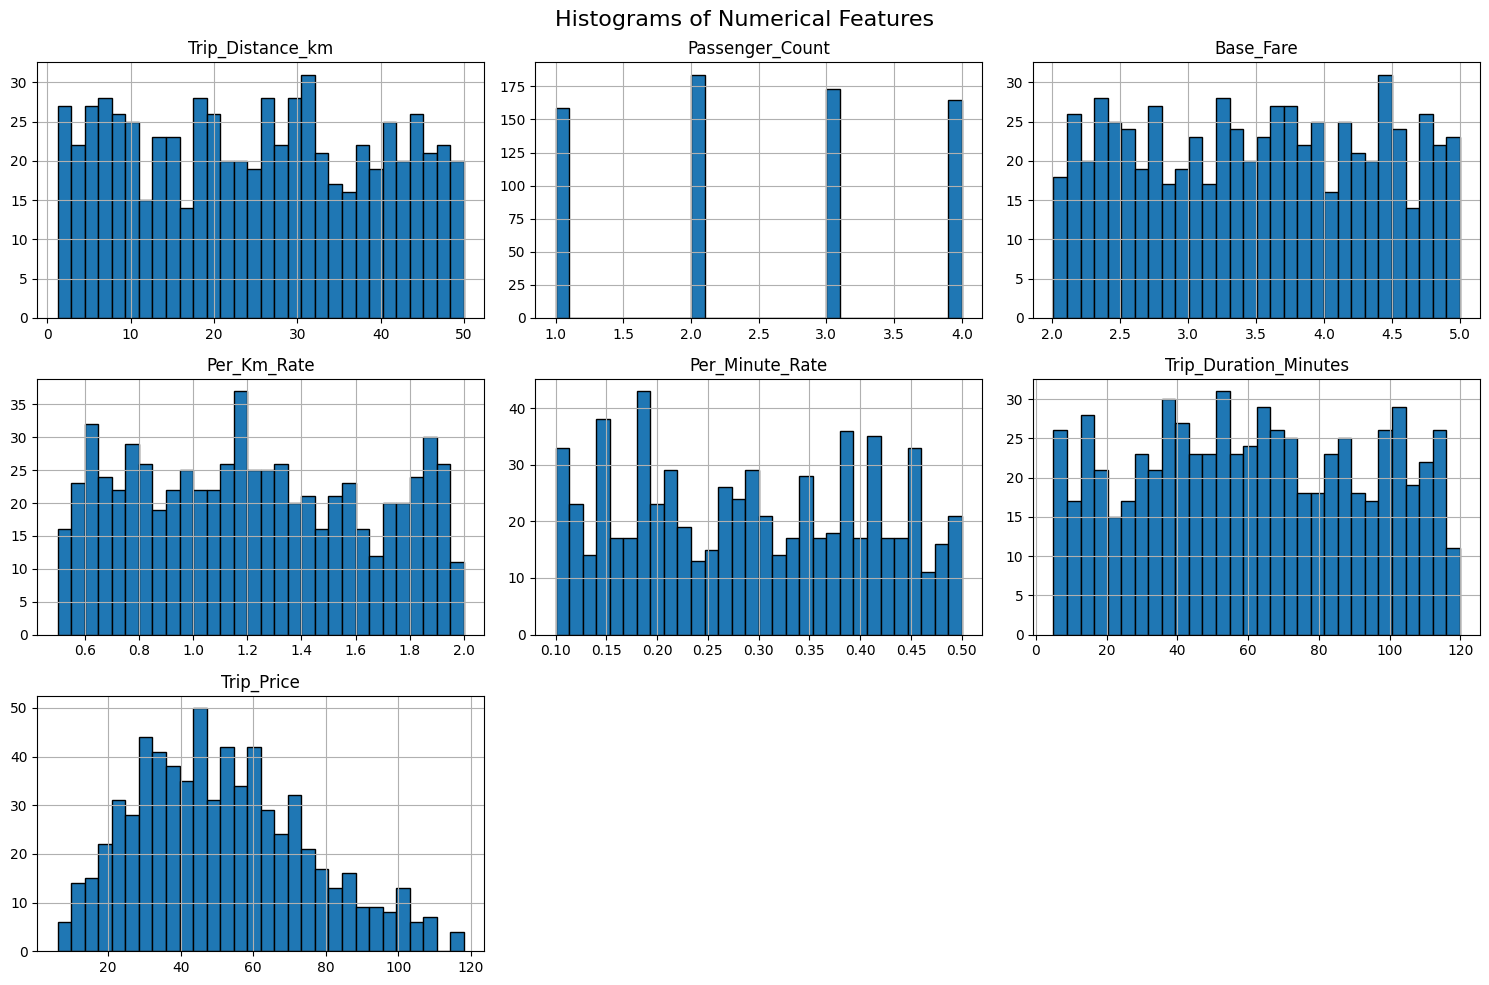

In [2]:
print(df.head())
print(df.info())
print(df.describe())
missing=df.isnull().sum()
print(missing)

#data cleaning
df.drop_duplicates(subset=None,keep='first',inplace=True)

#outlier removal
for col in df.select_dtypes(include='number').columns:
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3 - Q1

    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR

    df = df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]

#categorical datacleaning
for col in df.select_dtypes(include='object').columns:
    modeval=df[col].mode(dropna=True)
    df[col]=df[col].fillna(modeval[0])

#numerical datacleaning
for col in df.select_dtypes(include='number').columns:
    skewval=df[col].skew()
    if -0.5<skewval<0.5:
        df[col]=df[col].fillna(df[col].mean())
        method="mean"
    else:
        df[col]=df[col].fillna(df[col].median())
        method="median"

    print(f"{col}: skew={skewval:.3f},method={method}")

#outliers check
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
# histograms
df[numerical_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


data encoding

/tmp/ipython-input-960526688.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Day_of_Week']=df['Day_of_Week'].replace({"Weekday":1,"Weekend":0})
/tmp/ipython-input-960526688.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Traffic_Conditions"]=df["Traffic_Conditions"].replace({"Low":0,"Medium":1,"High":2})


    Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0              19.35            1              3.0                   0   
2              36.87            0              1.0                   2   
3              30.33            1              4.0                   0   
5               8.64            0              2.0                   1   
12             41.79            0              3.0                   2   

    Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
0        3.56         0.80             0.32                  53.82   
2        2.70         1.21             0.15                  37.27   
3        3.48         0.51             0.15                 116.81   
5        2.55         1.71             0.48                  89.33   
12       4.60         1.77             0.11                  86.95   

    Trip_Price  Time_of_Day_Evening  Time_of_Day_Morning  Time_of_Day_Night  \
0      36.2624                False                 Tru

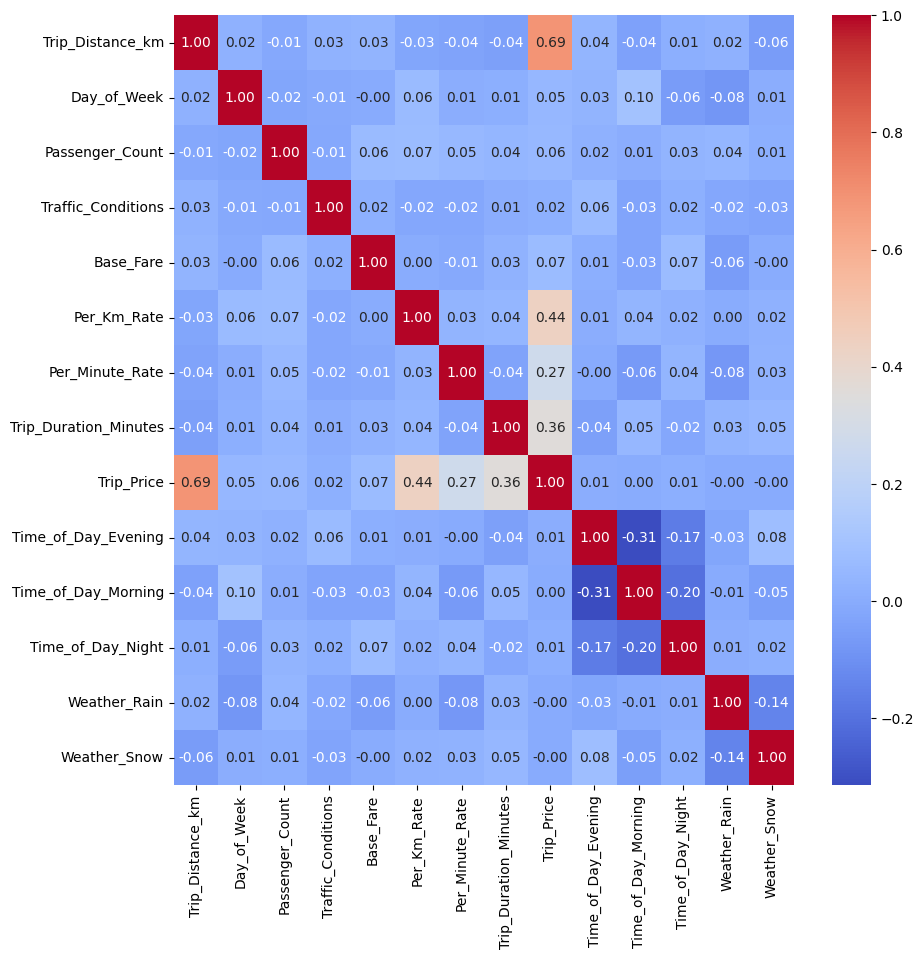

In [3]:
#encoding(hot,binary,ordinal)
df=pd.get_dummies(df,columns=['Time_of_Day','Weather'],drop_first=True)
df['Day_of_Week']=df['Day_of_Week'].replace({"Weekday":1,"Weekend":0})
df["Traffic_Conditions"]=df["Traffic_Conditions"].replace({"Low":0,"Medium":1,"High":2})
print(df.head())

#correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt=".2f")
plt.show()

define features and target values


In [4]:
X=df.drop("Trip_Price",axis=1)   # Features
Y=df["Trip_Price"]                # Target
print(X)
print(Y)

     Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0               19.35            1              3.0                   0   
2               36.87            0              1.0                   2   
3               30.33            1              4.0                   0   
5                8.64            0              2.0                   1   
12              41.79            0              3.0                   2   
..                ...          ...              ...                 ...   
990             40.17            1              3.0                   0   
992             14.34            1              1.0                   1   
994             18.69            1              3.0                   1   
995              5.49            0              4.0                   1   
998             47.56            1              1.0                   0   

     Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
0         3.56         0.80 

splitting and scaling the data

In [5]:
x_train,x_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
scaler=StandardScaler()
X_train=scaler.fit_transform(x_train)
X_test=scaler.transform(x_test)

creating and training the model

In [6]:
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

model predictions and evaluation

[ 1.72183882e+01  1.08416849e-02  7.69734412e-02  1.82455353e-01
  7.21109853e-01  1.01826353e+01  7.10998513e+00  8.97184087e+00
  1.31176280e-01  6.65796141e-01 -1.34457669e-01 -1.08589230e-01
  1.20904327e-02]
51.492760477941175


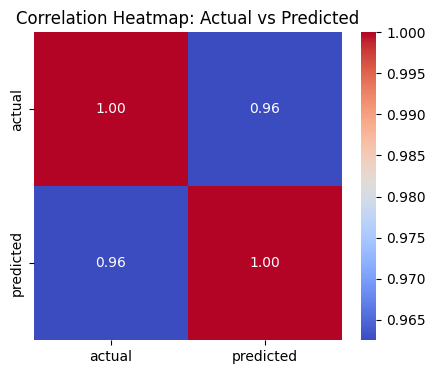

mean sbsolute rrror: 5.1090793586042915
mean dquared rrror: 42.153485871787936
root mean squared error: 6.492571591579714
R² Score: 0.9256305194489634


In [7]:
#prediction
Y_pred=model.predict(X_test)
print(model.coef_)
print(model.intercept_)

#heatmap btw actual vs predicted values
df_corr=pd.DataFrame({
    "actual":Y_test,
    "predicted":Y_pred
})

plt.figure(figsize=(5,4))
sns.heatmap(df_corr.corr(),annot=True,cmap="coolwarm",fmt=".2f",square=True)
plt.title("Correlation Heatmap: Actual vs Predicted")
plt.show()

#evaluation metrices
mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
r2=r2_score(Y_test,Y_pred)

print("mean sbsolute rrror:",mae)
print("mean dquared rrror:",mse)
print("root mean squared error:",rmse)
print("R² Score:",r2)


using ridge to improve accuracy (multicollinearity exists)

mean absolute error:  5.110279096840505
mean squared error:  42.19557982254209
R2 score:  0.9255562550035163


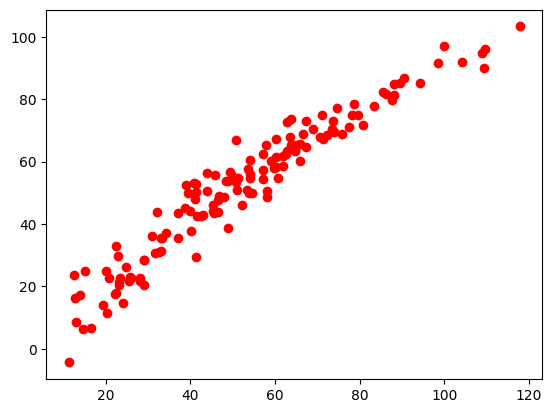

In [8]:
ridge=Ridge()
ridge.fit(X_train,Y_train)
Y_pred=ridge.predict(X_test)

mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
score=r2_score(Y_test,Y_pred)

print("mean absolute error: ",mae)
print("mean squared error: ",mse)
print("R2 score: ",score)

plt.scatter(Y_test,Y_pred,color="red")
plt.show()